# **1. Instalação**

In [1]:
%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm river


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# **2. Importação das Bibliotecas Auxiliares**

In [2]:
from preprocessamento.SeriesProcessor import SeriesProcessor
from frameworkDetector.framework_detector import FrameworkDetector # Sua classe principal
from utils.StreamProcessor import StreamProcessor # Seu processador de stream
from utils import Visualizer
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
from frameworkDetector.framework_detector import FrameworkDetector

from detectores.KSWINDetector import KSWINDetector
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo

# **3. Importação das Classes do Framework**

In [3]:
from preprocessamento.SeriesProcessor import SeriesProcessor
from frameworkDetector.framework_detector import FrameworkDetector
from utils.StreamProcessor import StreamProcessor
from utils import Visualizer

# **4. Importação de Detectores**

In [4]:
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

# **5. Importação de Modeos** 

In [5]:
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo


# **6. Lista de Séries Temporais**

In [6]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# **7. Definição de Parâmetros**

In [7]:
lags = 5
serie_escolhida = series[5]  # ^BVSP
print(f"Processando série: {serie_escolhida}")

# Parâmetros do framework
tamanho_janela = 200
intervalo_adicao_pool = 30
observacoes_novo_conceito = 55
detector_escolhido = "KSWIN"
tipo_modelo_inicial_global = RandomForestModelo
max_pool_size = 5
min_diversidade_erro = 0.05
n_clusters_regimes = 5
limiar_degradacao = 0.15
threshold_melhoria_alerta = 0.94
metrics_interval = 50
min_samples_for_metrics = 5

Processando série: ^BVSP


# **8. Obtenção e Pré-processamento dos Dados**

In [8]:
# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (20% dos dados)
initial_size = int(0.2 * len(X))
print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)
Tamanho do conjunto inicial de treinamento: 247 amostras
Shape do X_init: (247, 5)
Shape do Y_init: (247, 1)
Shape do X_stream: (992, 5)
Shape do Y_stream: (992, 1)


# **9. Inicialização do Framework - Modelo e Detector**

# 9.1 Treinar Modelo Inicial e Obter Scaler

# 9.3 Inicializar Detector

In [9]:
detector_escolhido = "KSWIN"  # Pode ser "DDM", "ADWIN", "KSWIN", "HDDM_W"

print(f"Inicializando detector: {detector_escolhido}")
if detector_escolhido == "DDM":
    from detectores.DDMDetector import DDM  # Importe sua classe DDM aqui
    detector = DDM()
elif detector_escolhido == "ADWIN":
    from detectores.ADWINDetector import ADWIN  # Importe sua classe ADWIN aqui
    detector = ADWIN(delta=0.002)
elif detector_escolhido == "KSWIN":
    from detectores.KSWINDetector import KSWIN  # Importe sua classe KSWIN aqui
    detector = KSWIN(alpha=0.05, window_size=100)
elif detector_escolhido == "HDDM_W":
    from detectores.HDDM_WDetector import HDDM_W  # Importe sua classe HDDM_W aqui
    detector = HDDM_W(drift_confidence=0.001, warning_confidence=0.005)
else:
    raise ValueError(f"Detector '{detector_escolhido}' não suportado ou não definido.")


Inicializando detector: KSWIN


# **10. Inicialização do StreamProcessor**

In [10]:
tamanho_janela = 100
intervalo_adicao_pool = 50
observacoes_novo_conceito = 50
max_pool_size = 5
tipo_modelo = "rf"  # Pode ser "rf", "sgd" ou "knn"

# Execute o framework
resultados = FrameworkDetector.executar_framework(
    X_init=X_init,
    y_init=y_init,
    X_stream=X_stream,
    y_stream=Y_stream,
    detector_externo=detector,
    tipo_modelo=tipo_modelo,
    tamanho_janela=tamanho_janela,
    intervalo_adicao_pool=intervalo_adicao_pool,
    observacoes_novo_conceito=observacoes_novo_conceito,
    max_pool_size=max_pool_size
)

/home/liedson/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



=== Inicialização do Framework ===
Modelo inicial (RandomForest) treinado com 247 amostras.

=== Iniciando Processamento do Stream ===


Stream: 100%|██████████| 992/992 [00:09<00:00, 105.46it/s]


=== Processamento concluído em 9.41 segundos ===
Número de drifts detectados: 0


# **11. Processamento do Stream**

In [11]:
print(f"\nIniciando processamento do stream com {len(X_stream)} amostras...")
start_time = time.time()

# Processamento do stream

end_time = time.time()
print(f"✓ Processamento do stream concluído em {end_time - start_time:.2f} segundos.")



Iniciando processamento do stream com 992 amostras...
✓ Processamento do stream concluído em 0.00 segundos.


# **12. Extração de Resultados**

# **13. Visualização de Resultados**

# 13.1 Análise Geral

# 13.2 Previsão vs Real

In [12]:
def visualizar_resultados(y_stream, resultados, X_init_len=None):
    """
    Visualiza os resultados do framework em gráficos.

    Parâmetros:
    -----------
    y_stream : array
        Valores reais do stream
    resultados : dict
        Dicionário retornado pela função executar_framework
    X_init_len : int, opcional
        Tamanho dos dados iniciais (para ajustar índices se necessário)
    """
    offset = X_init_len if X_init_len else 0

    # Plot das predições vs valores reais
    plt.figure(figsize=(15, 10))

    # Subplot 1: Valor Real vs. Previsão
    plt.subplot(3, 1, 1)
    plt.plot(range(len(y_stream)), y_stream, 'b-', label='Valor Real')
    plt.plot(range(len(resultados['predicoes'])), resultados['predicoes'], 'r--', label='Previsão')
    for drift in resultados['pontos_drift']:
        plt.axvline(x=drift-offset, color='k', linestyle=':', label='_nolegend_')
    plt.title("Valor Real vs. Previsão")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Erro Absoluto
    plt.subplot(3, 1, 2)
    plt.plot(resultados['erros'], 'r-', alpha=0.7)
    plt.title("Erro Absoluto")
    plt.grid(True, alpha=0.3)

    # Subplot 3: Tamanho do Pool de Modelos
    plt.subplot(3, 1, 3)
    plt.plot(resultados['tamanho_pool'], 'c-')
    plt.title("Tamanho do Pool de Modelos")
    plt.xlabel("Amostra")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Adicionalmente, pode-se plotar o RMSE periódico
    if resultados['indices_rmse']:
        plt.figure(figsize=(12, 5))
        plt.plot(resultados['indices_rmse'], resultados['valores_rmse'], 'b-o')
        plt.title("RMSE ao longo do tempo")
        plt.xlabel("Índice global")
        plt.ylabel("RMSE")
        plt.grid(True)
        plt.show()

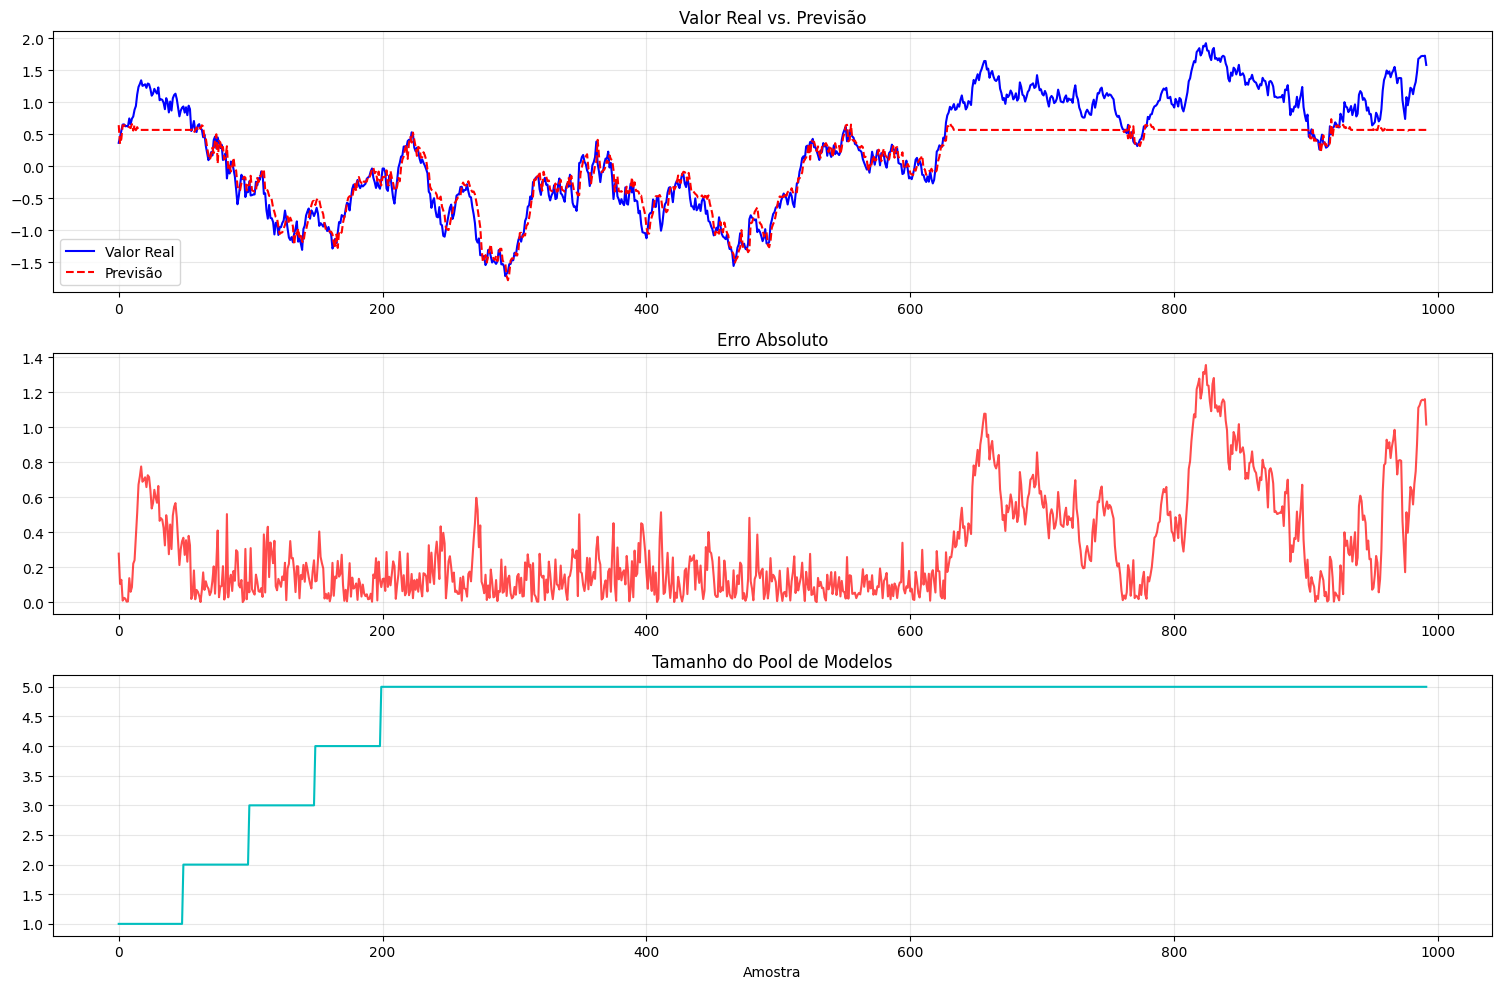

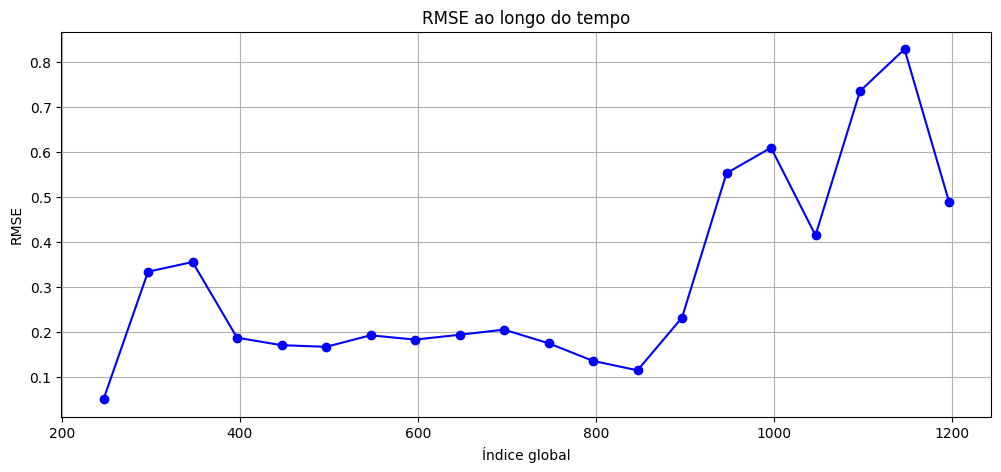

In [13]:
visualizar_resultados(Y_stream, resultados, len(X_init))